In [1]:
#prep data

In [2]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import numpy as np
import bs4
import time

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

from env import github_token, github_username

import acquire

In [3]:
df = pd.read_csv (r'f1_readmes.csv')

In [4]:
df.head()

,repo,language,readme_contents
0,ppatierno/formula1-telemetry-kafka,Java,# Formula 1 - Telemetry with Apache Kafka\n\nT...
1,NVIDIA-AI-IOT/Formula1Epoch,Makefile,[![logo.png](https://s2.postimg.org/fwiu26nmh/...
2,jcnewell/ergast-f1-api,PHP,# Ergast nodeJS API\nIn this period we are wor...
3,SOYJUN/FTP-implement-based-on-UDP,C,Copyright (c) 2014 Jun Zeng. <jun.zeng@stonybr...
4,daz/live-f1,C,live-f1 is a native Linux client for viewing t...


In [5]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt', '\n', 'ha']

def clean(readme_contents):
    
    'A simple function to cleanup text data'
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('portuguese') + ADDITIONAL_STOPWORDS
    readme_contents = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', readme_contents).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
null_readme = df[df['readme_contents'].isnull()].index

In [7]:
type(null_readme)

pandas.core.indexes.numeric.Int64Index

In [8]:
df.drop(null_readme , inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 325
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             268 non-null    object
 1   language         241 non-null    object
 2   readme_contents  268 non-null    object
dtypes: object(3)
memory usage: 8.4+ KB


In [10]:
#from textblob import TextBlob

In [11]:
#df['written_language'] = df['readme_contents'].apply(lambda content: translator.detect(content))

In [12]:
df.language.value_counts()

JavaScript          55
Python              28
HTML                20
C++                 14
Java                14
PHP                 14
C#                  13
TypeScript          13
Ruby                11
Jupyter Notebook     9
R                    8
C                    7
CSS                  7
Kotlin               4
Swift                3
Scala                2
TSQL                 2
PLpgSQL              2
Matlab               2
Go                   2
Makefile             1
Visual Basic         1
Verilog              1
Dart                 1
Pascal               1
SCSS                 1
PLSQL                1
F#                   1
q                    1
Shell                1
TeX                  1
Name: language, dtype: int64

In [13]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "language")

,n,percent
JavaScript,55,0.228216
Python,28,0.116183
HTML,20,0.082988
C++,14,0.058091
Java,14,0.058091
PHP,14,0.058091
C#,13,0.053942
TypeScript,13,0.053942
Ruby,11,0.045643
Jupyter Notebook,9,0.037344


In [14]:
# seperate the data into seperate pieces 

js = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))

python = clean(' '.join(df[df.language == 'Python'].readme_contents))

html = clean(' '.join(df[df.language == 'HTML'].readme_contents))

php = clean(' '.join(df[df.language == 'PHP'].readme_contents))

cplus = clean(' '.join(df[df.language == 'C++'].readme_contents))

java = clean(' '.join(df[df.language == 'Java'].readme_contents))

cpound = clean(' '.join(df[df.language == 'C#'].readme_contents))

type_script = clean(' '.join(df[df.language == 'TypeScript'].readme_contents))

ruby = clean(' '.join(df[df.language == 'Ruby'].readme_contents))

all_words = clean(' '.join(df.readme_contents))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 325
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             268 non-null    object
 1   language         241 non-null    object
 2   readme_contents  268 non-null    object
dtypes: object(3)
memory usage: 8.4+ KB


In [16]:
js_freq = pd.Series(js).value_counts()
python_freq = pd.Series(python).value_counts()
html_freq = pd.Series(html).value_counts()
php_freq = pd.Series(php).value_counts()
cplus_freq = pd.Series(cplus).value_counts()
java_freq = pd.Series(java).value_counts()
cpound_freq = pd.Series(cpound).value_counts()
type_script_freq = pd.Series(type_script).value_counts()
ruby_freq = pd.Series(ruby).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [17]:
word_counts = (pd.concat([all_freq,
                          js_freq,
                          python_freq,
                          html_freq,
                          php_freq,
                          cplus_freq,
                          java_freq,
                          cpound_freq,
                          type_script_freq,
                          ruby_freq], axis=1, sort=True)
                .set_axis(['all', 'js', 'python', 'html', 'php','cplus', 'java', 'cpound', 'typescript', 'ruby'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(10)

,all,js,python,html,php,cplus,java,cpound,typescript,ruby
0,135,3,39,1,1,71,13,0,0,0
00,3,0,0,0,0,1,0,0,0,0
0000,15,0,0,0,0,13,0,0,2,0
000000,1,0,0,0,0,1,0,0,0,0
000030,1,0,0,0,0,1,0,0,0,0
000040,1,0,0,0,0,1,0,0,0,0
0001,10,0,0,0,0,10,0,0,0,0
0002,4,0,0,0,0,4,0,0,0,0
0003,5,0,0,0,0,5,0,0,0,0
0004,5,0,0,0,0,5,0,0,0,0


Text(0.5, 1.0, 'Proportion of JavaScript vs Python for the 20 most common words')

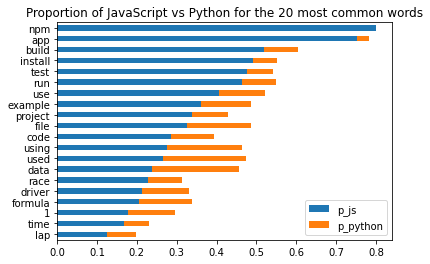

In [18]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_python=word_counts.python / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs Python for the 20 most common words')

Text(0.5, 1.0, 'Proportion of Python vs HTML for the 20 most common words')

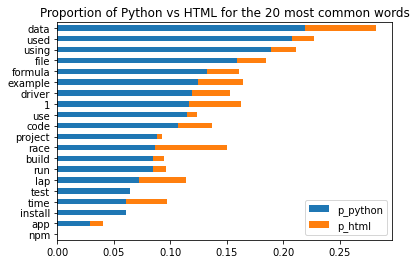

In [19]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_html']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs HTML for the 20 most common words')

Text(0.5, 1.0, 'Proportion of C++ vs Java for the 20 most common words')

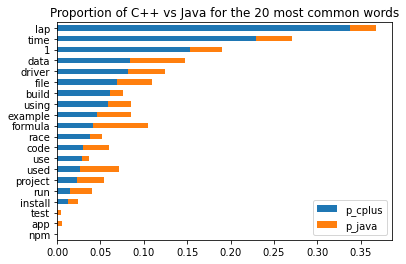

In [20]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_cplus=word_counts.cplus / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_cplus', 'p_java']]
 .tail(20)
 .sort_values('p_cplus')
 .plot.barh(stacked=True))

plt.title('Proportion of C++ vs Java for the 20 most common words')

Text(0.5, 1.0, 'Proportion of PHP vs Java for the 20 most common words')

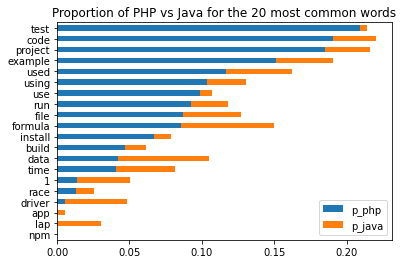

In [21]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_php=word_counts.php / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_php', 'p_java']]
 .tail(20)
 .sort_values('p_php')
 .plot.barh(stacked=True))

plt.title('Proportion of PHP vs Java for the 20 most common words')

Text(0.5, 1.0, 'Proportion of Python vs Java for the 20 most common words')

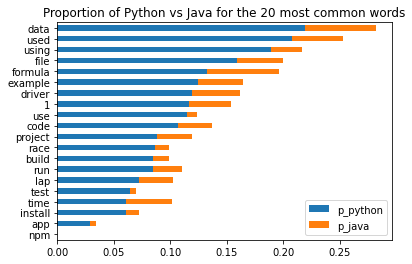

In [22]:
 # figure out the percentage of spam vs ham
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_java']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of Python vs Java for the 20 most common words')

In [23]:
# convert javascript to one string

js = ' '.join([str(elem) for elem in js])

In [24]:
# bigrams for JavaScript

bigrams_js = nltk.ngrams(js.split(), 2)
top_20_js_bigrams = pd.Series(bigrams_js).value_counts().head(20)

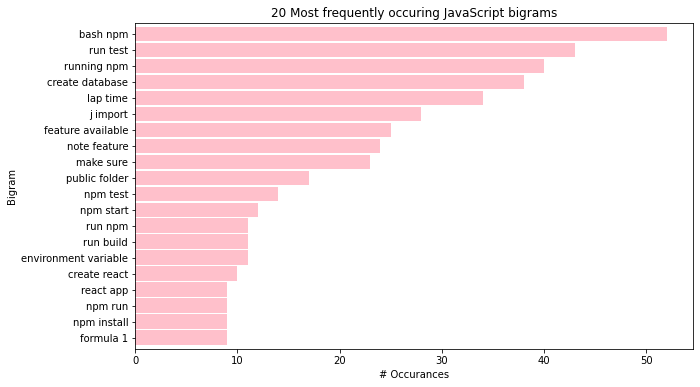

In [25]:
top_20_js_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [26]:
# convert python to one string

python = ' '.join([str(elem) for elem in python])



In [27]:
# bigrams for Python

bigrams_python = nltk.ngrams(python.split(), 2)
top_20_python_bigrams = pd.Series(bigrams_python).value_counts().head(20)

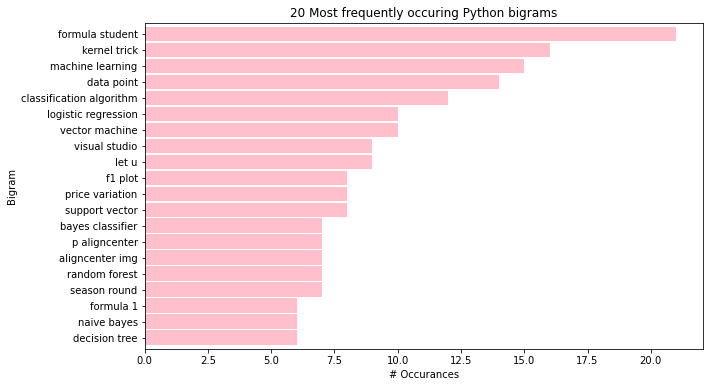

In [28]:
top_20_python_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [29]:
# convert html to one string

html = ' '.join([str(elem) for elem in html])

# bigrams for html

bigrams_html = nltk.ngrams(html.split(), 2)
top_20_html_bigrams = pd.Series(bigrams_html).value_counts().head(20)

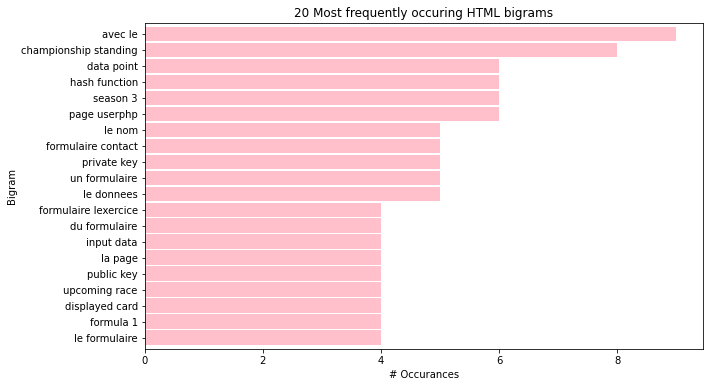

In [30]:
top_20_html_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring HTML bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [31]:
# convert cplus to one string

cplus = ' '.join([str(elem) for elem in cplus])

# bigrams for html

bigrams_cplus = nltk.ngrams(cplus.split(), 2)
top_20_cplus_bigrams = pd.Series(bigrams_cplus).value_counts().head(20)

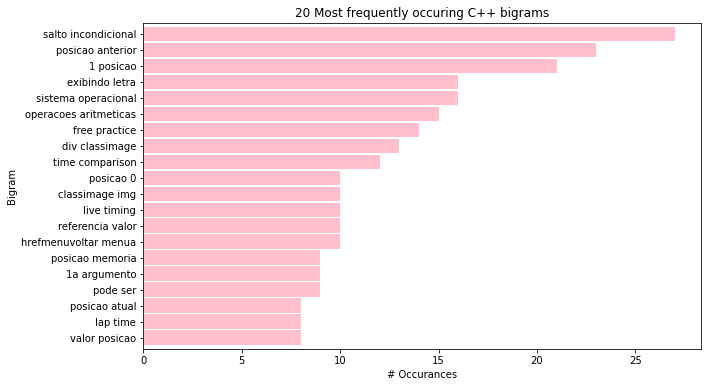

In [32]:
top_20_cplus_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring C++ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_cplus_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)